In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DATASET_PATH = "/content/drive/MyDrive/gesture_dataset"


if os.path.exists(DATASET_PATH):
    print(" Dataset found!")
else:
    print(" Dataset not found!")


 Dataset found!


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image size & batch size
IMG_SIZE = (224, 224)  # Resize images to 224x224 to fit the mobileNetv2 model
BATCH_SIZE = 32

# Image data generator to automatically labels images based on folder name
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH + "/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    DATASET_PATH + "/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

# Print class labels
print("Class Labels:", train_generator.class_indices)


Found 145 images belonging to 4 classes.
Found 35 images belonging to 4 classes.
Class Labels: {'love': 0, 'peace': 1, 'thumbsdown': 2, 'thumbsup': 3}


In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load MobileNetV2 without the top layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce size
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(4, activation="softmax")(x)  # Corrected: connect the output layer to `x`

# Create final model
model = Model(inputs=base_model.input, outputs=x)  # Use `x` instead of `output_layer`

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Show model summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,430,468 (9.27 MB)

 Trainable params: 172,484 (673.77 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# Train the model
EPOCHS = 10  # You can increase this later
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 74s 13s/step - accuracy: 0.2568 - loss: 1.6099 - val_accuracy: 0.6571 - val_loss: 0.9716
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6564 - loss: 0.8986 - val_accuracy: 0.9429 - val_loss: 0.5506
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8893 - loss: 0.5525 - val_accuracy: 0.9714 - val_loss: 0.2947
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9146 - loss: 0.3450 - val_accuracy: 1.0000 - val_loss: 0.1354
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9750 - loss: 0.2179 - val_accuracy: 0.9714 - val_loss: 0.1217
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9701 - loss: 0.1252 - val_accuracy: 0.9714 - val_loss: 0.0723
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9731 - loss: 0.0930 - val_accuracy: 0.9714 - val_loss: 0.0699
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9867 - loss: 0.0572 - val_accuracy: 0.9429 - val_loss: 0.1134
Epoch 9/10
5/

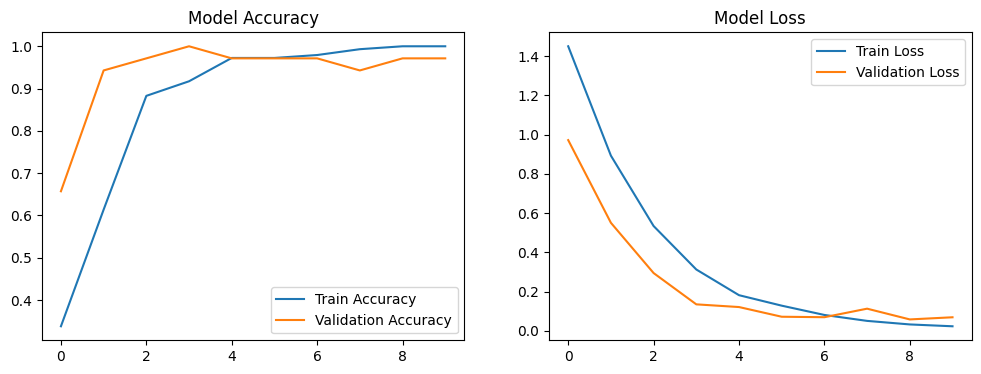

In [6]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Model Loss")

plt.show()


In [7]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = "/content/drive/MyDrive/gesture_dataset/test/sample3.jpg"  # Change this to your test image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)

# Map predictions to class labels
class_labels = {v: k for k, v in train_generator.class_indices.items()}  # Reverse mapping
predicted_label = class_labels[predicted_class]

print(f"Predicted Gesture: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Gesture: thumbsdown


In [8]:
!pip install mediapipe opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 29.4 MB/s eta 0:00:00


In [9]:
!pip install --upgrade mediapipe


In [10]:
import tensorflow as tf
import cv2
import mediapipe as mp

print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)
print("MediaPipe version:", mp.__version__)


TensorFlow version: 2.18.0
OpenCV version: 4.11.0
MediaPipe version: 0.10.21


In [21]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.preprocessing.image import img_to_array

# Load MediaPipe Hands model
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Open webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB (MediaPipe requires RGB input)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Detect hands in the frame
    results = hands.process(rgb_frame)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get bounding box coordinates
            h, w, c = frame.shape
            x_min, y_min, x_max, y_max = w, h, 0, 0
            for landmark in hand_landmarks.landmark:
                x, y = int(landmark.x * w), int(landmark.y * h)
                x_min, y_min = min(x_min, x), min(y_min, y)
                x_max, y_max = max(x_max, x), max(y_max, y)

            # Crop the hand region
            hand_img = frame[y_min:y_max, x_min:x_max]
            if hand_img.shape[0] > 0 and hand_img.shape[1] > 0:
                # Resize and preprocess for classification
                hand_img = cv2.resize(hand_img, (224, 224))
                hand_img = img_to_array(hand_img) / 255.0
                hand_img = np.expand_dims(hand_img, axis=0)

                # Predict gesture
                predictions = model.predict(hand_img)
                predicted_class = np.argmax(predictions)
                class_labels = {v: k for k, v in train_generator.class_indices.items()}  # Reverse mapping
                predicted_label = class_labels[predicted_class]

                # Draw bounding box and label
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                cv2.putText(frame, predicted_label, (x_min, y_min - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Draw hand landmarks
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Display output
    cv2.imshow("Hand Gesture Recognition", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

